In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 10.9MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 9.7MB/s 


In [2]:
!wget https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1 -O erm.zip

--2021-03-03 15:57:44--  https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/qrdswgzv63o3opg/datasetCorregido.zip [following]
--2021-03-03 15:57:44--  https://www.dropbox.com/s/dl/qrdswgzv63o3opg/datasetCorregido.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc97ec965f92247e7d69cffe186e.dl.dropboxusercontent.com/cd/0/get/BJ9SPXtWYkTwld8QS9fJby0wDAqvWTEFsICVUShcLRVsJfc5rGNxOVehJkTKcl3iahn87M6ZbIVzwbrWO8NzBql_BDfjz-C5aLt3WeXmJdWjWWpSZRvSRF1wDu8bnHP4IQE/file?dl=1# [following]
--2021-03-03 15:57:45--  https://uc97ec965f92247e7d69cffe186e.dl.dropboxusercontent.com/cd/0/get/BJ9SPXtWYkTwld8QS9fJby0wDAqvWTEFsICVUShcLRVsJfc5rGNxOVehJkTKcl3iahn87M6ZbIVzwbrWO8

In [3]:
!unzip erm.zip

Archive:  erm.zip
   creating: datasetCorregido/
   creating: datasetCorregido/train/
   creating: datasetCorregido/train/no/
  inflating: datasetCorregido/train/no/anonymized_482127.jpg  
  inflating: datasetCorregido/train/no/anonymized_174749.jpg  
  inflating: datasetCorregido/train/no/anonymized_734047.jpg  
  inflating: datasetCorregido/train/no/anonymized_581767.jpg  
  inflating: datasetCorregido/train/no/anonymized_1400777.jpg  
  inflating: datasetCorregido/train/no/anonymized_347431.jpg  
  inflating: datasetCorregido/train/no/anonymized_626433.jpg  
  inflating: datasetCorregido/train/no/anonymized_1372303.jpg  
  inflating: datasetCorregido/train/no/anonymized_1324599.jpg  
  inflating: datasetCorregido/train/no/anonymized_196853.jpg  
  inflating: datasetCorregido/train/no/anonymized_687000.jpg  
  inflating: datasetCorregido/train/no/anonymized_504041.jpg  
  inflating: datasetCorregido/train/no/anonymized_1414333.jpg  
  inflating: datasetCorregido/train/no/anonymized_3

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('datasetCorregido/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=360,max_warp=0,max_zoom=1.1,
                      max_lighting=0.1,p_lighting=0.5), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=32)

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18')
]

In [9]:
modelo='resnet50'

## Ranger

In [10]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [11]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50_ram-a26f946b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_ram-a26f946b.pth


SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=6.309573450380412e-07)

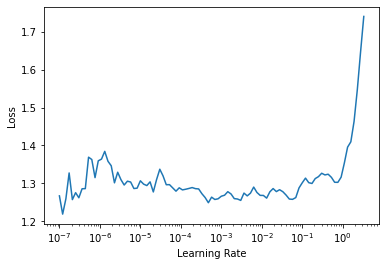

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.280612,1.015129,0.527523,0.535714,0.743440,00:31
1,1.239348,0.924879,0.530581,0.541284,0.688047,00:30


Better model found at epoch 0 with valid_loss value: 1.0151286125183105.


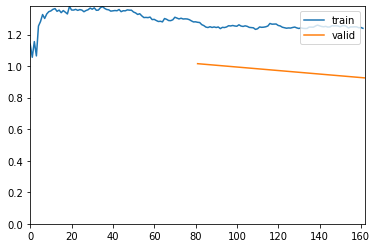

Better model found at epoch 1 with valid_loss value: 0.9248791337013245.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.168762,0.914297,0.530581,0.543062,0.661808,00:33
1,1.167545,0.907766,0.529052,0.544529,0.623907,00:34
2,1.203569,0.878302,0.513761,0.530713,0.629738,00:34
3,1.182481,0.856462,0.530581,0.549451,0.583090,00:34
4,1.123474,0.826582,0.538226,0.558405,0.571429,00:34
5,1.113724,0.816307,0.541284,0.552567,0.658892,00:34
6,1.084886,0.798922,0.535168,0.555874,0.565598,00:34
7,1.111351,0.799618,0.539755,0.550000,0.673469,00:34
8,1.066453,0.786863,0.545872,0.552995,0.699708,00:34
9,1.031967,0.774228,0.547401,0.557457,0.664723,00:34


Better model found at epoch 0 with valid_loss value: 0.9142969250679016.


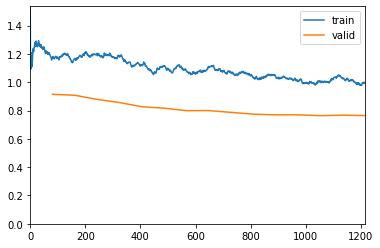

Better model found at epoch 1 with valid_loss value: 0.9077659845352173.
Better model found at epoch 2 with valid_loss value: 0.8783024549484253.
Better model found at epoch 3 with valid_loss value: 0.8564620018005371.
Better model found at epoch 4 with valid_loss value: 0.8265817761421204.
Better model found at epoch 5 with valid_loss value: 0.8163066506385803.
Better model found at epoch 6 with valid_loss value: 0.7989219427108765.
Better model found at epoch 8 with valid_loss value: 0.7868632078170776.
Better model found at epoch 9 with valid_loss value: 0.7742277383804321.
Better model found at epoch 10 with valid_loss value: 0.7693053483963013.
Better model found at epoch 12 with valid_loss value: 0.7637689113616943.


In [13]:
learn.fine_tune(15,freeze_epochs=2)

In [14]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

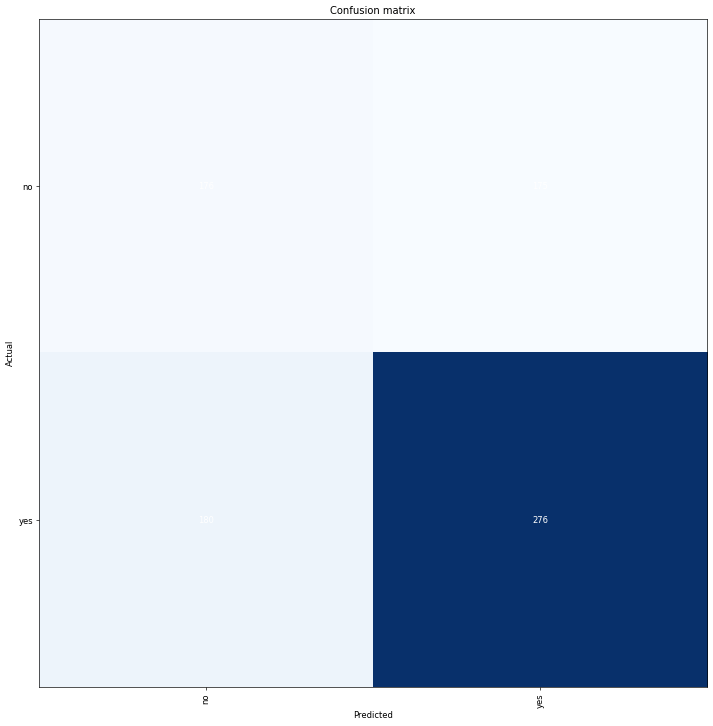

In [15]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [16]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5600991249084473.


(#4) [0.7382213473320007,0.5600991249084473,0.6119733924611973,0.6052631578947368]

## Faltten

In [17]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.250010,0.843938,0.574924,0.574032,0.734694,00:30
1,0.990457,0.787091,0.567278,0.592025,0.562682,00:30


Better model found at epoch 0 with valid_loss value: 0.8439381718635559.


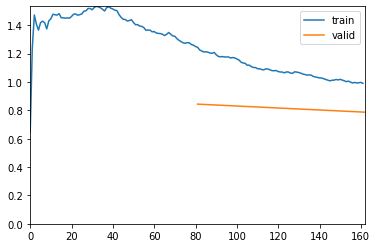

Better model found at epoch 1 with valid_loss value: 0.7870913743972778.


In [18]:
learn.fit_flat_cos(2,lr=1e-3)

In [19]:
learn.unfreeze()

SuggestedLRs(lr_min=9.999999747378752e-07, lr_steep=3.311311274956097e-06)

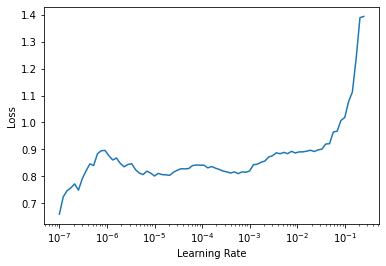

In [20]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.106186,1.046682,0.521407,0.524590,0.932945,00:33
1,1.151888,1.349992,0.513761,0.523540,0.810496,00:33
2,1.028006,0.762802,0.513761,0.520194,0.938776,00:33
3,1.046904,0.735296,0.475535,0.500000,0.002915,00:33
4,1.073289,0.765711,0.522936,0.523810,0.994169,00:33
5,1.101399,1.705236,0.516820,0.544554,0.481050,00:33
6,1.032763,0.845365,0.519878,0.524046,0.921283,00:33


Better model found at epoch 0 with valid_loss value: 1.0466821193695068.


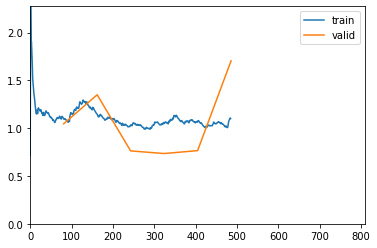

Better model found at epoch 2 with valid_loss value: 0.762802243232727.
Better model found at epoch 3 with valid_loss value: 0.7352957129478455.
No improvement since epoch 3: early stopping


In [21]:
learn.fit_flat_cos(10,lr=1e-2)

In [22]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

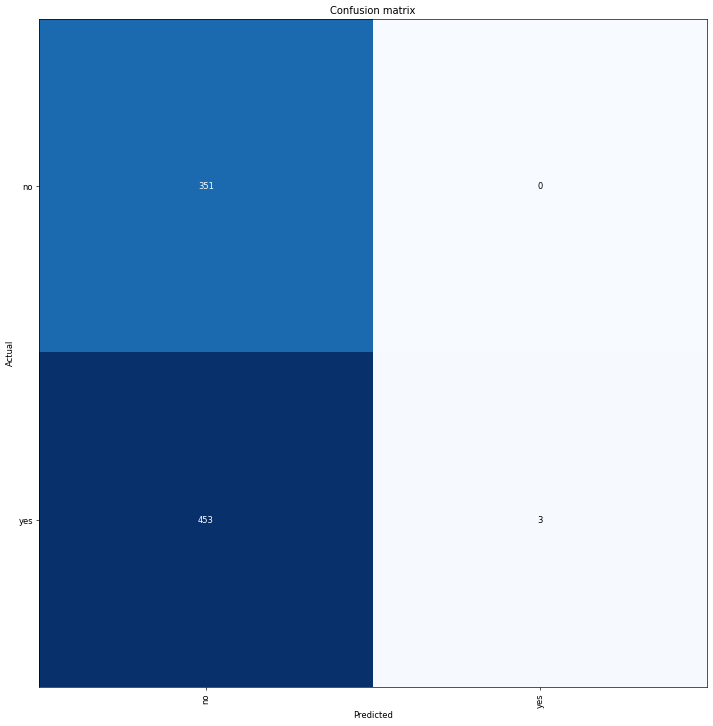

In [23]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [24]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.43866172432899475.


(#4) [0.7279485464096069,0.43866172432899475,1.0,0.006578947368421052]

## LabelSmoothing

In [25]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=9.999999747378752e-06)

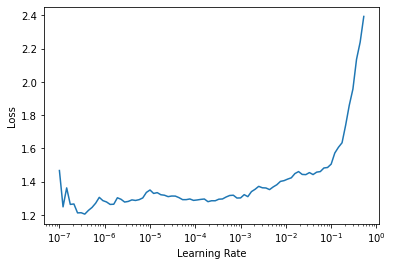

In [26]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.370323,1.153032,0.515290,0.579268,0.276968,00:30
1,1.062739,0.781643,0.541284,0.589212,0.413994,00:30


Better model found at epoch 0 with valid_loss value: 1.1530317068099976.


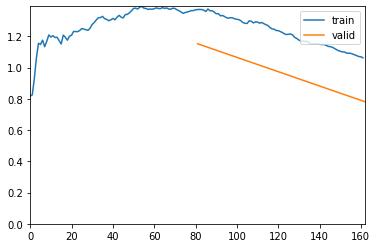

Better model found at epoch 1 with valid_loss value: 0.7816433906555176.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.814929,0.724690,0.559633,0.630332,0.387755,00:33
1,0.759924,0.678654,0.605505,0.630769,0.597668,00:33
2,0.747095,0.701947,0.591743,0.574219,0.857143,00:34
3,0.727903,0.682677,0.570336,0.563265,0.804665,00:33
4,0.694967,0.670343,0.597859,0.625000,0.583090,00:33
5,0.668501,0.644984,0.636086,0.647887,0.670554,00:33
6,0.654294,0.650053,0.637615,0.757282,0.454810,00:33
7,0.631265,0.645051,0.651376,0.725490,0.539359,00:33
8,0.611316,0.637214,0.666667,0.694704,0.650146,00:33
9,0.598643,0.635886,0.686544,0.771654,0.571429,00:33


Better model found at epoch 0 with valid_loss value: 0.7246901392936707.


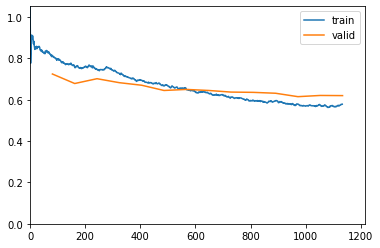

Better model found at epoch 1 with valid_loss value: 0.6786543130874634.
Better model found at epoch 4 with valid_loss value: 0.6703428030014038.
Better model found at epoch 5 with valid_loss value: 0.6449843049049377.
Better model found at epoch 8 with valid_loss value: 0.6372135877609253.
Better model found at epoch 9 with valid_loss value: 0.6358863711357117.
Better model found at epoch 10 with valid_loss value: 0.6315779685974121.
Better model found at epoch 11 with valid_loss value: 0.6150363087654114.
No improvement since epoch 11: early stopping


In [27]:
learn.fine_tune(15,freeze_epochs=2)

In [28]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

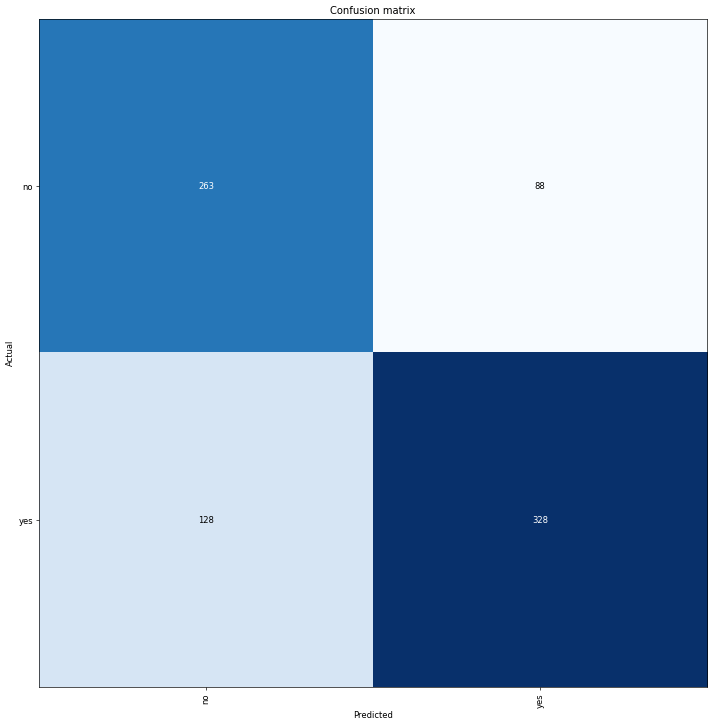

In [29]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [30]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.732342004776001.


(#4) [0.5689550638198853,0.732342004776001,0.7884615384615384,0.7192982456140351]

## MixUp

In [35]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [36]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.329683,1.799997,0.496942,0.554688,0.206997,00:31
1,1.109735,0.826390,0.522936,0.577114,0.338192,00:31


Better model found at epoch 0 with valid_loss value: 1.7999966144561768.


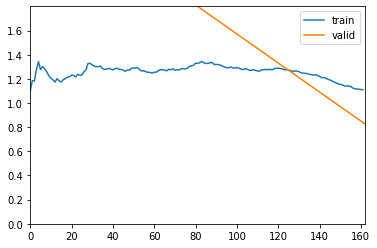

Better model found at epoch 1 with valid_loss value: 0.8263904452323914.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.842497,0.714742,0.559633,0.567901,0.670554,00:34
1,0.802541,0.699584,0.579511,0.571730,0.790087,00:34
2,0.770768,0.699017,0.567278,0.586705,0.591837,00:34
3,0.737292,0.741133,0.547401,0.632768,0.326531,00:34
4,0.706079,0.688890,0.593272,0.679070,0.425656,00:34
5,0.687270,0.745532,0.536697,0.537879,0.827988,00:34
6,0.677956,0.701523,0.584098,0.660633,0.425656,00:34
7,0.662053,0.655217,0.620795,0.787879,0.379009,00:34
8,0.648564,0.627514,0.637615,0.664596,0.623907,00:33
9,0.633336,0.625544,0.657492,0.703072,0.600583,00:34


Better model found at epoch 0 with valid_loss value: 0.7147423624992371.


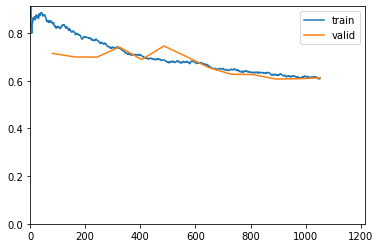

Better model found at epoch 1 with valid_loss value: 0.6995844841003418.
Better model found at epoch 2 with valid_loss value: 0.6990167498588562.
Better model found at epoch 4 with valid_loss value: 0.6888898611068726.
Better model found at epoch 7 with valid_loss value: 0.655216634273529.
Better model found at epoch 8 with valid_loss value: 0.6275143623352051.
Better model found at epoch 9 with valid_loss value: 0.6255444884300232.
Better model found at epoch 10 with valid_loss value: 0.6072185635566711.
No improvement since epoch 10: early stopping


In [37]:
learn.fine_tune(15,freeze_epochs=2)

In [38]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

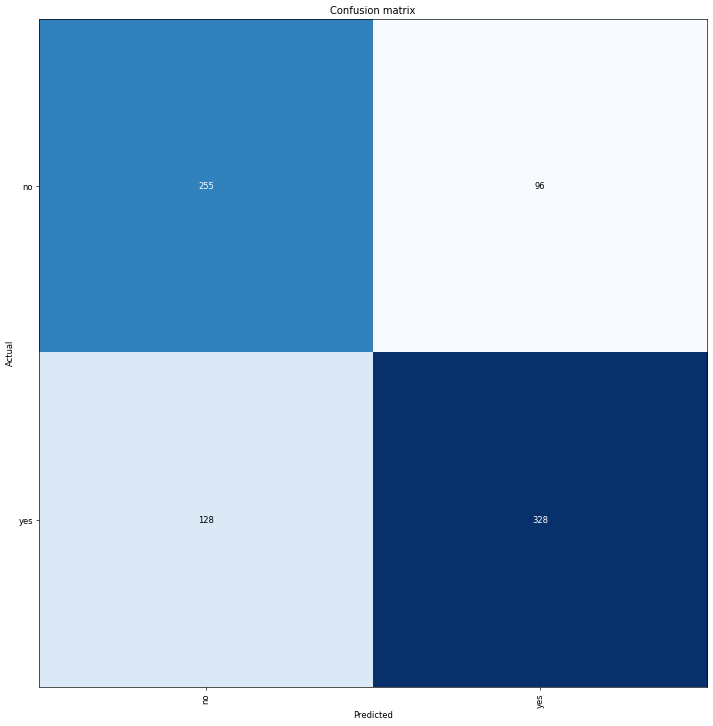

In [39]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [40]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7224287390708923.


(#4) [0.5566040277481079,0.7224287390708923,0.7735849056603774,0.7192982456140351]

## Ranger + Flat cosin Anneal

In [41]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.307894,0.915348,0.507645,0.526055,0.618076,00:31
1,1.225231,0.907819,0.527523,0.536957,0.720117,00:30


Better model found at epoch 0 with valid_loss value: 0.9153479933738708.


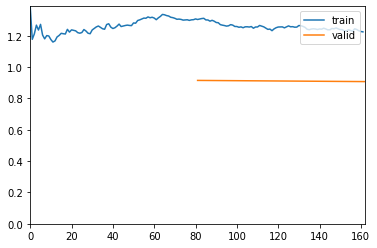

Better model found at epoch 1 with valid_loss value: 0.9078192114830017.


In [42]:
learn.fit_flat_cos(2,lr=1e-3)

In [43]:
learn.unfreeze()

SuggestedLRs(lr_min=1.58489319801447e-07, lr_steep=6.309573450380412e-07)

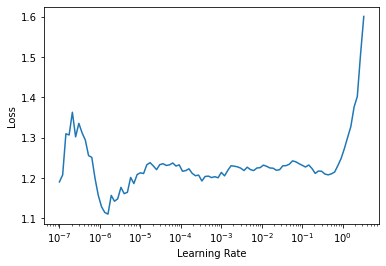

In [44]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.137152,0.889135,0.495413,0.538012,0.268222,00:34
1,1.037980,0.757856,0.567278,0.575758,0.664723,00:34
2,0.934575,0.749684,0.530581,0.578947,0.384840,00:34
3,0.856992,0.747505,0.532110,0.543735,0.670554,00:34
4,0.798572,0.744624,0.504587,0.561290,0.253644,00:34
5,0.765286,0.686269,0.567278,0.650000,0.379009,00:34
6,0.712501,0.699773,0.571865,0.668449,0.364431,00:34
7,0.700079,0.684584,0.588685,0.643411,0.483965,00:34
8,0.673757,0.679685,0.587156,0.662222,0.434402,00:34
9,0.656166,0.680135,0.585627,0.669811,0.413994,00:34


Better model found at epoch 0 with valid_loss value: 0.88913494348526.


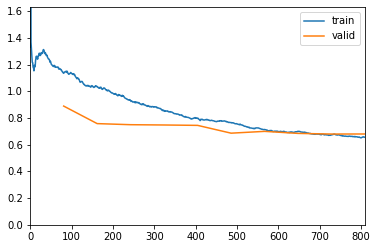

Better model found at epoch 1 with valid_loss value: 0.7578555345535278.
Better model found at epoch 2 with valid_loss value: 0.749683678150177.
Better model found at epoch 3 with valid_loss value: 0.7475051879882812.
Better model found at epoch 4 with valid_loss value: 0.744623601436615.
Better model found at epoch 5 with valid_loss value: 0.6862694025039673.
Better model found at epoch 7 with valid_loss value: 0.6845839619636536.
Better model found at epoch 8 with valid_loss value: 0.6796845197677612.


In [45]:
learn.fit_flat_cos(10,lr=1e-2)

In [46]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [47]:
learn.dls = dlsTest

In [48]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5662949085235596.


(#4) [0.6844122409820557,0.5662949085235596,0.6853146853146853,0.4298245614035088]

## Ranger+Flar Cossin Anneal+LabelSmoothing

In [49]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.282988,0.891658,0.521407,0.542373,0.559767,00:31
1,1.245191,0.882470,0.500000,0.529851,0.413994,00:31


Better model found at epoch 0 with valid_loss value: 0.8916580080986023.


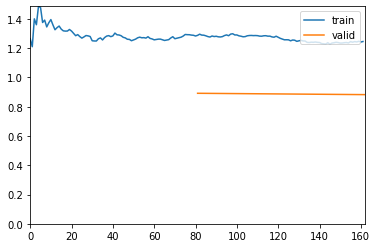

Better model found at epoch 1 with valid_loss value: 0.882469892501831.


In [50]:
learn.fit_flat_cos(2,lr=1e-3)

In [51]:
learn.unfreeze()

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=2.75422871709452e-06)

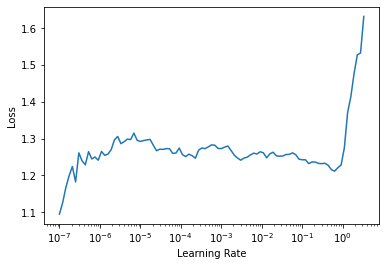

In [52]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.189892,0.856530,0.510703,0.538721,0.466472,00:34
1,1.069142,0.861256,0.513761,0.591241,0.236152,00:34
2,0.954763,0.733271,0.533639,0.559375,0.521866,00:34
3,0.847381,0.715859,0.529052,0.552239,0.539359,00:34
4,0.794971,0.704239,0.519878,0.536524,0.620991,00:34
5,0.753710,0.699260,0.530581,0.567164,0.443149,00:34
6,0.722999,0.679269,0.570336,0.579082,0.661808,00:34
7,0.708543,0.679493,0.559633,0.577904,0.594752,00:34
8,0.696437,0.675503,0.570336,0.585165,0.620991,00:34
9,0.692533,0.676009,0.582569,0.622378,0.518950,00:34


Better model found at epoch 0 with valid_loss value: 0.8565298914909363.


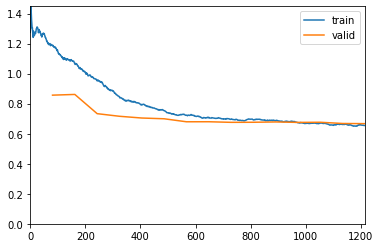

Better model found at epoch 2 with valid_loss value: 0.733270525932312.
Better model found at epoch 3 with valid_loss value: 0.7158588767051697.
Better model found at epoch 4 with valid_loss value: 0.7042394876480103.
Better model found at epoch 5 with valid_loss value: 0.6992602348327637.
Better model found at epoch 6 with valid_loss value: 0.6792688369750977.
Better model found at epoch 8 with valid_loss value: 0.6755030155181885.
Better model found at epoch 11 with valid_loss value: 0.6750957369804382.
Better model found at epoch 13 with valid_loss value: 0.6678691506385803.
Better model found at epoch 14 with valid_loss value: 0.6668480634689331.


In [53]:
learn.fit_flat_cos(15,lr=1e-2)

In [54]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [55]:
learn.dls = dlsTest

In [56]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6059479713439941.


(#4) [0.6582250595092773,0.6059479713439941,0.7053571428571429,0.5197368421052632]

## Ranger +Flat + Label + MixUp

In [63]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.326526,1.140549,0.500000,0.590909,0.151603,00:31
1,1.246253,1.079430,0.516820,0.633663,0.186589,00:31


Better model found at epoch 0 with valid_loss value: 1.1405487060546875.


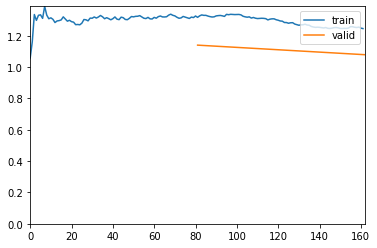

Better model found at epoch 1 with valid_loss value: 1.0794302225112915.


In [64]:
learn.fit_flat_cos(2,lr=1e-3)

In [65]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.203644,0.868010,0.486239,0.510903,0.478134,00:34
1,1.082555,0.791634,0.506116,0.537879,0.413994,00:34
2,0.958790,0.727817,0.522936,0.551839,0.481050,00:34
3,0.863277,0.740543,0.501529,0.537118,0.358601,00:34
4,0.800213,0.724378,0.510703,0.574194,0.259475,00:34
5,0.752043,0.722585,0.493884,0.529703,0.311953,00:34
6,0.727223,0.695266,0.527523,0.585859,0.338192,00:34
7,0.717862,0.685778,0.544343,0.562674,0.588921,00:34
8,0.711453,0.682619,0.550459,0.557377,0.693878,00:35
9,0.699413,0.690252,0.542813,0.618280,0.335277,00:35


Better model found at epoch 0 with valid_loss value: 0.8680102825164795.


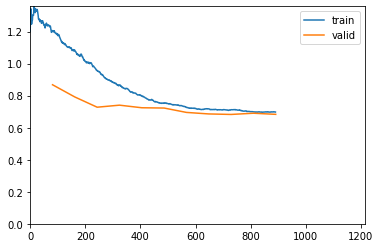

Better model found at epoch 1 with valid_loss value: 0.7916337251663208.
Better model found at epoch 2 with valid_loss value: 0.7278172373771667.
Better model found at epoch 4 with valid_loss value: 0.7243784070014954.
Better model found at epoch 5 with valid_loss value: 0.7225850820541382.
Better model found at epoch 6 with valid_loss value: 0.6952656507492065.
Better model found at epoch 7 with valid_loss value: 0.6857782006263733.
Better model found at epoch 8 with valid_loss value: 0.6826192736625671.
No improvement since epoch 8: early stopping


In [66]:
learn.fit_flat_cos(15,lr=1e-2)

In [67]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

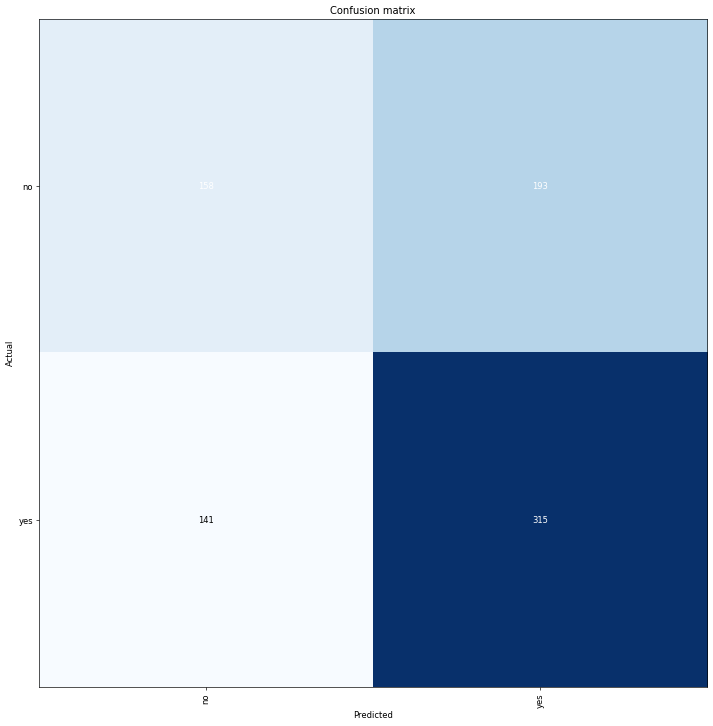

In [68]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [69]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5861214399337769.


(#4) [0.6776275038719177,0.5861214399337769,0.6200787401574803,0.6907894736842105]

## Ranger + Flat + MixUp

In [76]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [77]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.275886,1.009512,0.486239,0.511706,0.446064,00:31
1,1.303138,0.972875,0.475535,0.500000,0.387755,00:31


Better model found at epoch 0 with valid_loss value: 1.0095115900039673.


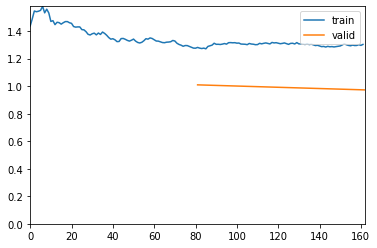

Better model found at epoch 1 with valid_loss value: 0.9728751182556152.


In [78]:
learn.fit_flat_cos(2,lr=1e-3)

In [79]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.265239,1.047502,0.538226,0.538899,0.827988,00:34
1,1.104101,1.554152,0.478593,0.600000,0.017493,00:35
2,0.981038,0.902465,0.513761,0.526096,0.734694,00:35
3,0.886596,0.810624,0.484709,0.875000,0.020408,00:35
4,0.807883,0.698877,0.521407,0.594937,0.274052,00:35
5,0.756575,0.705643,0.521407,0.581522,0.311953,00:35
6,0.734576,0.710076,0.524465,0.728571,0.148688,00:34
7,0.730630,0.682630,0.553517,0.556044,0.737609,00:35
8,0.718216,0.682979,0.555046,0.586667,0.513120,00:35
9,0.714051,0.717825,0.478593,0.515152,0.099125,00:35


Better model found at epoch 0 with valid_loss value: 1.047501802444458.


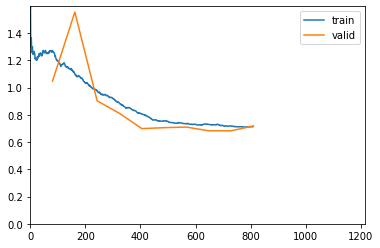

Better model found at epoch 2 with valid_loss value: 0.9024650454521179.
Better model found at epoch 3 with valid_loss value: 0.8106242418289185.
Better model found at epoch 4 with valid_loss value: 0.698876678943634.
Better model found at epoch 7 with valid_loss value: 0.6826296448707581.
No improvement since epoch 7: early stopping


In [80]:
learn.fit_flat_cos(15,lr=1e-2)

In [81]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [82]:
learn.dls = dlsTest

In [83]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5935564041137695.


(#4) [0.6693556904792786,0.5935564041137695,0.6126760563380281,0.7631578947368421]

## Ranger + MixUp

In [88]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [89]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.289536,0.851223,0.519878,0.541076,0.556851,00:31
1,1.270258,0.824671,0.522936,0.542936,0.571429,00:31


Better model found at epoch 0 with valid_loss value: 0.8512228727340698.


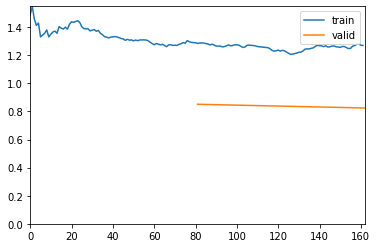

Better model found at epoch 1 with valid_loss value: 0.8246712684631348.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.257112,0.837083,0.555046,0.560185,0.705539,00:34
1,1.238636,0.827356,0.516820,0.537190,0.568513,00:35
2,1.219583,0.818988,0.536697,0.556497,0.574344,00:35
3,1.179741,0.797167,0.548930,0.567416,0.588921,00:35
4,1.190557,0.815277,0.550459,0.557110,0.696793,00:35
5,1.131687,0.795529,0.558104,0.563679,0.696793,00:35
6,1.125085,0.790803,0.547401,0.580205,0.495627,00:35
7,1.116962,0.775731,0.536697,0.565789,0.501458,00:35
8,1.072853,0.771106,0.548930,0.570175,0.568513,00:35
9,1.114519,0.771355,0.562691,0.571788,0.661808,00:35


Better model found at epoch 0 with valid_loss value: 0.8370826840400696.


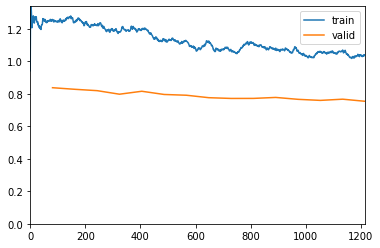

Better model found at epoch 1 with valid_loss value: 0.8273559808731079.
Better model found at epoch 2 with valid_loss value: 0.8189877271652222.
Better model found at epoch 3 with valid_loss value: 0.7971673607826233.
Better model found at epoch 5 with valid_loss value: 0.7955291271209717.
Better model found at epoch 6 with valid_loss value: 0.7908028364181519.
Better model found at epoch 7 with valid_loss value: 0.7757307291030884.
Better model found at epoch 8 with valid_loss value: 0.7711060643196106.
Better model found at epoch 11 with valid_loss value: 0.7656517624855042.
Better model found at epoch 12 with valid_loss value: 0.7591170072555542.
Better model found at epoch 14 with valid_loss value: 0.753600537776947.


In [90]:
learn.fine_tune(15,freeze_epochs=2)

In [91]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [92]:
learn.dls = dlsTest

In [93]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5390334725379944.


(#4) [0.7669865489006042,0.5390334725379944,0.5905172413793104,0.6008771929824561]

## Faltten + MixUp

In [99]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.310108,0.877243,0.565749,0.561331,0.787172,00:32
1,0.988636,0.722343,0.576453,0.597633,0.588921,00:31


Better model found at epoch 0 with valid_loss value: 0.8772427439689636.


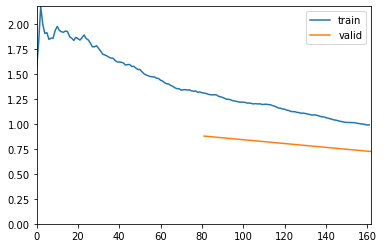

Better model found at epoch 1 with valid_loss value: 0.7223426103591919.


In [100]:
learn.fit_flat_cos(2,lr=1e-3)

In [101]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.000106,0.698859,0.524465,0.524465,1.000000,00:34
1,1.073324,111.638535,0.492355,0.567901,0.134111,00:34
2,0.987626,0.707732,0.474006,0.333333,0.002915,00:34
3,0.973041,0.787615,0.472477,0.333333,0.005831,00:34


Better model found at epoch 0 with valid_loss value: 0.6988587975502014.


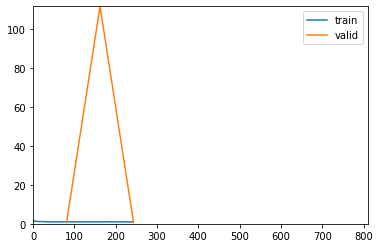

No improvement since epoch 0: early stopping


In [102]:
learn.fit_flat_cos(10,lr=1e-2)

In [103]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [104]:
learn.dls = dlsTest

In [105]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.565055787563324.


(#4) [0.6852887272834778,0.565055787563324,0.5650557620817844,1.0]

## Ranger + Label

In [106]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [107]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.346643,0.967880,0.496942,0.526515,0.405248,00:31
1,1.319353,0.923492,0.506116,0.552083,0.309038,00:32


Better model found at epoch 0 with valid_loss value: 0.9678803086280823.


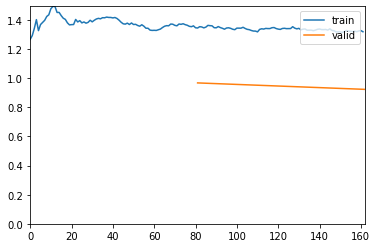

Better model found at epoch 1 with valid_loss value: 0.9234915971755981.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.235186,0.858416,0.527523,0.568548,0.411079,00:34
1,1.196345,0.840828,0.529052,0.570281,0.413994,00:34
2,1.234184,0.829343,0.524465,0.562016,0.422741,00:34
3,1.207107,0.862966,0.519878,0.575130,0.323615,00:34
4,1.216163,0.887065,0.509174,0.569620,0.262391,00:35
5,1.157523,0.797204,0.527523,0.570833,0.399417,00:34
6,1.105702,0.791710,0.541284,0.581749,0.446064,00:35
7,1.096000,0.786010,0.532110,0.574899,0.413994,00:35
8,1.087090,0.801934,0.545872,0.613861,0.361516,00:35
9,1.056528,0.767203,0.539755,0.577778,0.454810,00:34


Better model found at epoch 0 with valid_loss value: 0.8584155440330505.


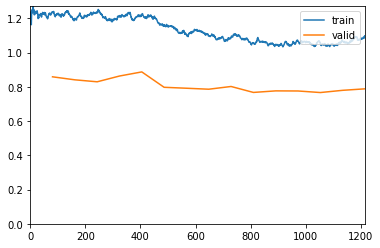

Better model found at epoch 1 with valid_loss value: 0.8408283591270447.
Better model found at epoch 2 with valid_loss value: 0.8293431997299194.
Better model found at epoch 5 with valid_loss value: 0.797203779220581.
Better model found at epoch 6 with valid_loss value: 0.7917104363441467.
Better model found at epoch 7 with valid_loss value: 0.786010205745697.
Better model found at epoch 9 with valid_loss value: 0.7672030925750732.
Better model found at epoch 12 with valid_loss value: 0.7665660977363586.


In [108]:
learn.fine_tune(15,freeze_epochs=2)

In [109]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [110]:
learn.dls = dlsTest

In [111]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5254027247428894.


(#4) [0.7979207634925842,0.5254027247428894,0.6262975778546713,0.3969298245614035]

## Faltten + Label

In [112]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.184849,0.821587,0.570336,0.586111,0.615160,00:31
1,0.923008,0.796657,0.562691,0.553672,0.857143,00:31


Better model found at epoch 0 with valid_loss value: 0.8215866684913635.


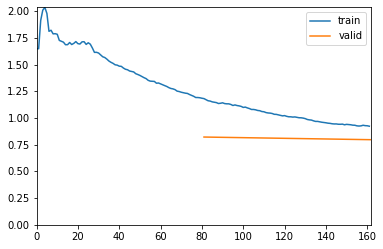

Better model found at epoch 1 with valid_loss value: 0.7966569662094116.


In [113]:
learn.fit_flat_cos(2,lr=1e-3)

In [114]:
learn.unfreeze()

SuggestedLRs(lr_min=2.290867705596611e-05, lr_steep=3.311311274956097e-06)

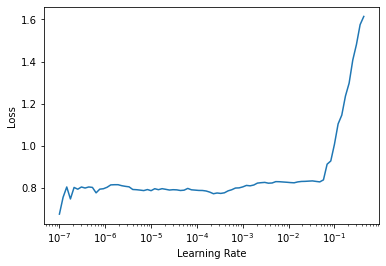

In [115]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.967437,0.888990,0.474006,0.484848,0.046647,00:34
1,1.038751,1.640933,0.506116,0.518116,0.833819,00:34
2,1.001855,7.450970,0.516820,0.536986,0.571429,00:34
3,1.063896,15.923506,0.518349,0.523256,0.918367,00:34


Better model found at epoch 0 with valid_loss value: 0.8889896273612976.


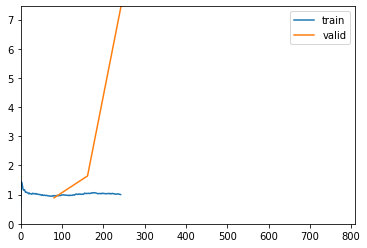

No improvement since epoch 0: early stopping


In [116]:
learn.fit_flat_cos(10,lr=1e-2)

In [117]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [118]:
learn.dls = dlsTest

In [119]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.4535315930843353.


(#4) [0.8146700263023376,0.4535315930843353,0.6744186046511628,0.06359649122807018]

## Label + MixUp

In [123]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.322098,1.163588,0.555046,0.565657,0.653061,00:31
1,1.074177,0.858080,0.547401,0.580205,0.495627,00:31


Better model found at epoch 0 with valid_loss value: 1.1635881662368774.


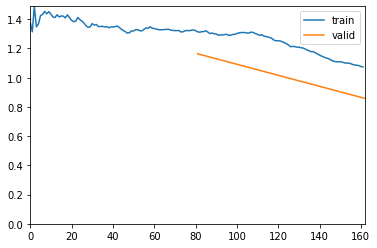

Better model found at epoch 1 with valid_loss value: 0.8580799102783203.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.823262,0.729697,0.555046,0.552000,0.804665,00:34
1,0.783072,0.702532,0.553517,0.565891,0.638484,00:34
2,0.745446,0.684625,0.591743,0.600529,0.661808,00:34
3,0.735275,0.683336,0.585627,0.598901,0.635569,00:34
4,0.715172,0.677996,0.605505,0.659176,0.513120,00:34
5,0.689346,0.661273,0.611621,0.627507,0.638484,00:34
6,0.682827,0.686859,0.588685,0.725610,0.346939,00:34
7,0.665268,0.660827,0.593272,0.637993,0.518950,00:34
8,0.666805,0.659643,0.614679,0.628169,0.650146,00:34
9,0.654938,0.646913,0.640673,0.682432,0.588921,00:34


Better model found at epoch 0 with valid_loss value: 0.7296966910362244.


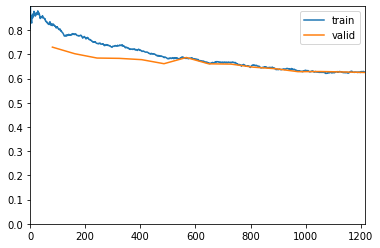

Better model found at epoch 1 with valid_loss value: 0.702531635761261.
Better model found at epoch 2 with valid_loss value: 0.6846250891685486.
Better model found at epoch 3 with valid_loss value: 0.683336079120636.
Better model found at epoch 4 with valid_loss value: 0.6779964566230774.
Better model found at epoch 5 with valid_loss value: 0.6612730622291565.
Better model found at epoch 7 with valid_loss value: 0.6608273386955261.
Better model found at epoch 8 with valid_loss value: 0.6596434116363525.
Better model found at epoch 9 with valid_loss value: 0.6469128131866455.
Better model found at epoch 10 with valid_loss value: 0.6405245065689087.
Better model found at epoch 11 with valid_loss value: 0.6283513903617859.
Better model found at epoch 13 with valid_loss value: 0.6273001432418823.
Better model found at epoch 14 with valid_loss value: 0.6249774694442749.


In [124]:
learn.fine_tune(15,freeze_epochs=2)

In [125]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [126]:
learn.dls = dlsTest

In [127]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7174721360206604.


(#4) [0.5805245637893677,0.7174721360206604,0.7688679245283019,0.7149122807017544]